In [1]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [3]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[2]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [4]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6tdiff_dt10/'
file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [5]:
#get fields psi
pfile = dir0 + file0

#wind forcing
forcing_z = dir0 + file1

#buyoancy forcing
forcing_b = dir0 + file1

f1 = netcdf.netcdf_file(dir0 + file0,'r')


In [6]:
N2,f0 = qg.reshape3d(dh,N2,f0)

si_t = f1.variables['time'][:].copy().size

p = qg.read_qgcm(pfile, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nl,N,naux = p.shape

test = si_t

average = True

In [7]:
%%time
# compute means (loop)


p_me = np.zeros((nl,N,N))
w_me = np.zeros((nl-1,N,N))
f_me = np.zeros((N,N))
d_me = np.zeros((N,N))
taux_me = np.zeros((N,N))
tauy_me = np.zeros((N,N))
u_me = np.zeros((nl,N,N))
v_me = np.zeros((nl,N,N))

n_me = 1
for it in range(0,test):
  
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    
    loc_forcing_z = qg.read_qgcm(forcing_z, it, 'wekt', rescale=f0/dh[0], interp=False)
    
    #sst = qg.read_qgcm(forcing_b, it, 'sst',rescale = 1, interp=False)
    #wekt = loc_forcing_z*dh[0]/f0   
    #entoc = -0.5*wekt*( sst - toc[0] ) /(toc[0]-toc[1])
    #loc_forcing_b = entoc - np.mean(entoc)
    loc_forcing_b = qg.read_qgcm(pfile, it, var='entoc', interp = True)

    w = qg.get_w(p,dh, N2,f0, Delta, bf,loc_forcing_z, loc_forcing_b, nu=0, nu4=nu4)
    
    tauy = qg.read_qgcm(pfile, it, var='tauy', rescale = 1/dh[0], interp = True)
    taux = qg.read_qgcm(pfile, it, var='taux', rescale = 1/dh[0], interp = True)
    
    u,v = qg.comp_vel(p, Delta=Delta, loc='center')
    u_me += (u - u_me)/n_me
    v_me += (v - v_me)/n_me
  
    p_me += (p - p_me)/n_me
    w_me += (w - w_me)/n_me
    f_me += (loc_forcing_z - f_me)/n_me
    d_me += (loc_forcing_b - d_me)/n_me
    taux_me += (taux-taux_me)/n_me 
    tauy_me += (tauy-tauy_me)/n_me 
    n_me += 1

CPU times: user 8min 22s, sys: 16.4 s, total: 8min 38s
Wall time: 24min 14s


In [8]:
#dealing with the terms strating from our averages

z_me = qg.laplacian(p_me,Delta)
b_me = qg.p2b(p_me, dh, f0)
s_me = qg.p2stretch(p_me,dh, N2,f0)
q_me = qg.p2q(p_me, dh, N2,f0, Delta)
ke_me = qg.comp_ke(p_me,Delta)
pe_me = qg.comp_pe(p_me, dh, N2,f0, Delta)

  
e_surf   = np.zeros((nl,N,N))
e_bottom = np.zeros((nl,N,N))
e_diab   = np.zeros((nl-1,N,N))
  
dissip_k_me = -nu4*qg.laplacian(qg.laplacian(z_me,Delta),Delta)
  
bottom_ekman = -bf*qg.laplacian(p_me[-1,:,:],Delta)
  
e_surf[0,:,:] = -p_me[0,:,:]*f_me
e_bottom[-1,:,:] = -p_me[-1,:,:]*bottom_ekman
  
e_diab[0,:,:] = b_me[0,:,:]*d_me



In [9]:
# save terms 
np.savez('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/termes_flot_moyen_rel.npz',
         e_surf=e_surf,
         e_diab=e_diab,
         e_dissip_k=-p_me*dissip_k_me,
         ke_me=ke_me, 
         pe_me=pe_me,
         e_bottom=e_bottom,
         w_b_me=w_me*b_me,
         taux_me=taux_me,
         tauy_me=tauy_me,
         u_me=u_me,
         v_me=v_me)

np.savez('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_flot_moyen_rel.npz',
         surf_me = f_me,
         diab_me = d_me,
         dissip_me = dissip_k_me,
         b_me = b_me,
         p_me = p_me,
         bottom_ekman_me = e_bottom,
         w_me = w_me)




In [10]:
#integral sur tous le domaine : termes

ei_surf_me   = qg.integral(e_surf, dh, Delta, average)
ei_bottom_me = qg.integral(e_bottom, dh, Delta, average)
ei_diss_k_me = qg.integral(-p_me*dissip_k_me, dh, Delta, average)
ei_wb_me     = qg.integral(w_me*b_me, dh, Delta, average)
ei_diab_me   = qg.integral(e_diab, dh, Delta, average)

#energies flot moyen
  
ei_ke_me = qg.integral(ke_me, dh, Delta, average)
ei_pe_me = qg.integral(pe_me, dh, Delta, average)

In [14]:
k,fl = qg.get_spec_flux(psi1 = b_me,psi2 = b_me,Delta=Delta)
fl_z = integral_z(psi = fl, dh=dh, Delta=Delta, Ht=Ht_b)
n_k = fl_z.shape

In [11]:
%%time

# compute all terms of dissipation
ei_ke   = np.zeros(si_t)
ei_pe   = np.zeros(si_t)
ei_surf   = np.zeros(si_t)
ei_bottom = np.zeros(si_t)
ei_diss_k = np.zeros(si_t)
ei_diss_p = np.zeros(si_t)
ei_wb     = np.zeros(si_t)
ei_ke_me2ke_p = np.zeros(si_t)
ei_pe_me2pe_p = np.zeros(si_t)
ei_diab     = np.zeros(si_t)

e_surf_p_me   = np.zeros((N,N))
e_bottom_p_me = np.zeros((nl,N,N))
e_diab_p_me   = np.zeros((nl-1,N,N))
pe_p_me = np.zeros((nl-1,N,N))
ke_p_me = np.zeros((nl,N,N))
w_b_p_me = np.zeros((nl-1,N,N))
e_dissip_p_me = np.zeros((nl,N,N))
ke_me2ke_p_me = np.zeros((nl,N,N))
pe_me2pe_p_me = np.zeros((nl-1,N,N))


surf_p_me   = np.zeros((nl,N,N))
bottom_p_me = np.zeros((nl,N,N))
diab_p_me   = np.zeros((nl-1,N,N))
w_p_me = np.zeros((nl-1,N,N))
dissip_p_me = np.zeros((nl,N,N))

#fl_vt_p_me = np.zeros((n_k))
#fl_bottom_p_me = np.zeros((n_k))
#fl_diab_p_me = np.zeros((n_k))
#fl_w_p_me = np.zeros((n_k))
#fl_dissip_p_me = np.zeros((n_k))



jac_ke = np.zeros((nl,N,N))
jac_pe = np.zeros((nl,N,N))

p_p_me = np.zeros((nl-1,N,N))
b_p_me = np.zeros((nl,N,N))

n_me=1

for it in range(0,test):
    
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    
    loc_forcing_z = qg.read_qgcm(forcing_z, it, 'wekt', rescale=f0/dh[0], interp=False)
    
    loc_forcing_b = qg.read_qgcm(pfile, it, var='entoc', interp = True)
    
    u,v = qg.comp_vel(p, Delta=Delta, loc='center')
    tauy = qg.read_qgcm(pfile, it, var='tauy', rescale = 1/dh[0], interp = True)
    taux = qg.read_qgcm(pfile, it, var='taux', rescale = 1/dh[0], interp = True)
    

    z = qg.laplacian(p,Delta)
    b = qg.p2b(p, dh, f0)
    s = qg.p2stretch(p,dh, N2,f0)
    w = qg.get_w(p,dh, N2,f0, Delta, bf,loc_forcing_z, forcing_b, nu=0, nu4 = nu4)
    q = qg.p2q(p, dh, N2,f0, Delta)
    ke = qg.comp_ke(p,Delta)
    pe = qg.comp_pe(p, dh, N2,f0, Delta)
  
    p_p = p - p_me
    z_p = z - z_me
    b_p = b - b_me 
    s_p = s - s_me
    w_p = w - w_me
    q_p = q - q_me
    ke_p = ke - ke_me
    pe_p = pe - pe_me
    u_p = u-u_me
    v_p = v-v_me
    taux_p = taux-taux_me
    tauy_p = tauy-tauy_me
    
    p_p_b = reduce_z_dim(p_p,dh)
    
     
    jpz = qg.jacobian(p_p,z_p, Delta)
    jps = qg.jacobian(p_p,s_p, Delta)
  
    ke_me2ke_p = -p_me*jpz
    pe_me2pe_p = -p_me*jps
    
    dissip_k = -nu4*qg.laplacian(qg.laplacian(z_p,Delta),Delta)
    
    # termes pour dissipation phys
    dissip_ke_phys = -nu4*(u_p*qg.laplacian(qg.laplacian(u_p,Delta),Delta)
                     + v_p*qg.laplacian(qg.laplacian(v_p,Delta),Delta))
                           

    bottom_ekman = -bf*qg.laplacian(p_p[-1,:,:],Delta)
  
    e_surf[0,:,:] = -p_p[0,:,:]*(loc_forcing_z - f_me)
    e_bottom[-1,:,:] = -p_p[-1,:,:]*bottom_ekman

    e_diab[0,:,:] = b_p[0,:,:]*(loc_forcing_b - d_me)

# mean for saving (physical)
    e_surf_p_me += (u_p[0]*taux_p+v_p[0]*tauy_p-e_surf_p_me)/n_me
    e_diab_p_me   += (e_diab - e_diab_p_me)/n_me
    pe_p_me += (pe_p - pe_p_me)/n_me
    ke_p_me += (ke_p - ke_p_me)/n_me
    w_b_p_me += (w_p*b_p - w_b_p_me)/n_me
    e_dissip_p_me += (dissip_ke_phys + e_dissip_p_me)/n_me
    
#spectral

#    k_vt_p_me, fl_vt_p_me_use = qg.get_spec_flux(psi1 =-p_p[0,:,:] ,psi2 = loc_forcing_z - f_me , Delta=Delta )
#    fl_vt_p_me += (fl_vt_p_me_use - fl_vt_p_me)/n_me
    
#    k_bottom_p_me, fl_bottom_p_me_use = qg.get_spec_flux(psi1 =-p_p[-1,:,:] ,psi2 = bottom_ekman , Delta=Delta )
#    fl_bottom_p_me += (fl_bottom_p_me_use - fl_bottom_p_me)/n_me
    
#    k_diab_p_me, fl_diab_p_me_use = qg.get_spec_flux(psi1 =b_p[0] ,psi2 = loc_forcing_b - d_me , Delta=Delta )
#    fl_diab_p_me += (fl_diab_p_me_use - fl_diab_p_me)/n_me
    
#    k_w_p_me, fl_w_p_me_use = qg.get_spec_flux(psi1 = w_p ,psi2 = b_p , Delta=Delta )
#    fl_w_p_me += (integral_z(psi =fl_w_p_me_use, dh = dh, Delta = Delta, Ht = Ht_b) - fl_w_p_me)/n_me
    
#    k_dissip_p_me, fl_dissip_p_me_use = qg.get_spec_flux(psi1 =-p_p, psi2 = dissip_k, Delta=Delta)
#    fl_dissip_p_me += (integral_z(psi =fl_dissip_p_me_use, dh = dh, Delta = Delta, Ht = Ht) - fl_dissip_p_me)/n_me
    
    
#    jac_ke += (jpz - jac_ke)/n_me
#    jac_pe += (jps - jac_pe)/n_me
    
    n_me += 1
    
#integrals
    ei_ke_me2ke_p[it] = qg.integral(ke_me2ke_p, dh, Delta, average)
    ei_pe_me2pe_p[it] = qg.integral(pe_me2pe_p, dh, Delta, average)
    ei_surf[it]   = qg.integral(e_surf, dh, Delta, average)
    ei_bottom[it] = qg.integral(e_bottom, dh, Delta, average)
    ei_diss_k[it] = qg.integral(-p_p*dissip_k, dh, Delta, average)
    ei_wb[it]     = qg.integral(w_p*b_p, dh, Delta, average)
    ei_ke[it]     = qg.integral(ke_p, dh, Delta, average)
    ei_pe[it]     = qg.integral(pe_p, dh, Delta, average)
    ei_diab[it]   = qg.integral(e_diab, dh, Delta, average)

CPU times: user 12min 56s, sys: 16.7 s, total: 13min 13s
Wall time: 18min 11s


In [12]:
#save terms of diff

np.savez('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/meom_test/Lorenz_cycle/tableaux_termes_rel/termes_perturbation_rel.npz',
         e_surf_p_me = e_surf_p_me,
         e_diab_p_me = e_diab_p_me,
         dissip_k_p_me = -p_me*dissip_k_me,
         ke_p_me = ke_p_me,
         pe_p_me = pe_p_me,
         e_bottom_p_me = e_bottom_p_me,
         w_b_p_me = w_b_p_me,
         ke_me2ke_p_me = ke_me2ke_p_me,
         pe_me2pe_p_me = pe_me2pe_p_me)

#np.savez('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/tableaux_termes_rel/etapes_perturbation_rel.npz',
#         k_vt_p_me = k_vt_p_me,
#         fl_vt_p_me = fl_vt_p_me,
#         k_diab_p_me = k_diab_p_me,
#         fl_diab_p_me = fl_diab_p_me,
#         k_dissip_p_me = k_dissip_p_me,
#         fl_dissip_p_me = fl_dissip_p_me,
#         k_bottom_p_me = k_bottom_p_me,
#         fl_bottom_p_me = fl_bottom_p_me,
#         k_w_p_me = k_w_p_me,
#         fl_w_p_me = fl_w_p_me,
#         jac_ke = jac_ke,
#         jac_pe = jac_pe)



In [13]:
# sign convention matches name
lec = {}
lec["f2mke"]   = ei_surf_me             
lec["f2eke"]   = np.mean(ei_surf)
lec["f2mpe"]   = ei_diab_me             
lec["f2epe"]   = np.mean(ei_diab)
lec["mke2mpe"] = -ei_wb_me              
lec["epe2eke"] = np.mean(ei_wb)         
lec["mke2eke"] = np.mean(ei_ke_me2ke_p) 
lec["mpe2epe"] = np.mean(ei_pe_me2pe_p) 
lec["mke2dis"] = -ei_diss_k_me          
lec["eke2dis"] = -np.mean(ei_diss_k)    
#lec["mpe2dis"] = -ei_diss_p_me          
lec["epe2dis"] = -np.mean(ei_diss_p)    
lec["mke2bf"]  = -ei_bottom_me          
lec["eke2bf"]  = -np.mean(ei_bottom)    
lec["mke"]     = ei_ke_me      
lec["eke"]     = np.mean(ei_ke)
lec["mpe"]     = ei_pe_me      
lec["epe"]     = np.mean(ei_pe)

lec["mpe2dis"] = 0



lec["average"] = average

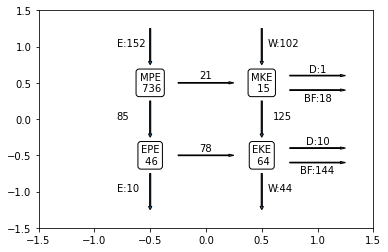

In [14]:
qg.draw_lorenz_cycle(lec = lec, us = 0.01, ts = 365*86400)
#plt.savefig('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/figs_rel/lorenz_cycle_rel_10_ans.png')